In [1]:
import sys
sys.path.append('cocoapi\PythonAPI')
from pycocotools.coco import COCO
from data_loader import get_loader
from torchvision import transforms
from torchvision.utils import make_grid, save_image
# TODO #1: Define a transform to pre-process the testing images.
transform_test = transforms.Compose([ 
    transforms.Resize(256),                          
    transforms.CenterCrop(224),                             
    transforms.ToTensor(),                           
    transforms.Normalize((0.485, 0.456, 0.406),      
                         (0.229, 0.224, 0.225))])

#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Create the data loader.
data_loader = get_loader(transform=transform_test, mode='test')

Vocabulary successfully loaded from vocab.pkl file!


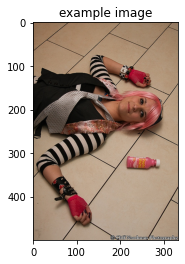

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Obtain sample image before and after pre-processing.
orig_image, image = next(iter(data_loader))

# Visualize sample image, before pre-processing.
plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()

In [2]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
import os
from PIL import Image
image = Image.open(os.path.join("images", "vase.png")).convert('RGB')

In [18]:
%load_ext autoreload
%autoreload 2

import os
import torch
from model import EncoderCNN, DecoderRNN

# TODO #2: Specify the saved models to load.
encoder_file = 'encoder-1.pkl'
decoder_file = 'decoder-1.pkl'

# TODO #3: Select appropriate values for the Python variables below.
embed_size = 512
hidden_size = 512

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()
print(os.getcwd())
address = os.path.join(os.getcwd(),'models', encoder_file)
print(address)
# Load the trained weights.
encoder.load_state_dict(torch.load(address))
decoder.load_state_dict(torch.load(os.path.join(os.getcwd(),'models', decoder_file)))

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
9 2048
C:\Users\ACER\PycharmProjects\firstTest\Image-Captioning-master
C:\Users\ACER\PycharmProjects\firstTest\Image-Captioning-master\models\encoder-1.pkl


DecoderRNN(
  (word_embeddings): Embedding(10321, 512)
  (embed): Embedding(10321, 512)
  (lstm): LSTM(512, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=10321, bias=True)
)

In [6]:
for c in decoder.children():
    print(c)
print([*decoder.children()][2])

Embedding(10321, 512)
Embedding(10321, 512)
LSTM(512, 512, batch_first=True)
Linear(in_features=512, out_features=10321, bias=True)


In [1]:
# Move image Pytorch Tensor to GPU if CUDA is available.
image = image.to(device)

# Obtain the embedded image features.
features = encoder(image).unsqueeze(1)

# Pass the embedded image features through the model to get a predicted caption.
output = decoder.sample(features)
print('example output:', output)

assert (type(output)==list), "Output needs to be a Python list" 
assert all([type(x)==int for x in output]), "Output should be a list of integers." 
assert all([x in data_loader.dataset.vocab.idx2word for x in output]), "Each entry in the output needs to correspond to an integer that indicates a token in the vocabulary."

NameError: name 'image' is not defined

In [13]:
# TODO #4: Complete the function.
def clean_sentence(output):
    sentence = ""
    for idx in output:
        if idx == 0:
            continue
        if idx == 1:
            break
        word = data_loader.dataset.vocab.idx2word[idx]
        sentence = sentence + word + ' '
        
    return sentence

In [11]:
sentence = clean_sentence(output)
print('example sentence:', sentence)

assert type(sentence)==str, 'Sentence needs to be a Python string!'

NameError: name 'output' is not defined

In [14]:
def get_prediction():
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
#     orig_image = orig_image.cpu()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
#     print(features)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)
    return features,image,orig_image


INTEGRATING GRAD CAM


In [15]:
from gradcam import GradCAM
from datetime import datetime

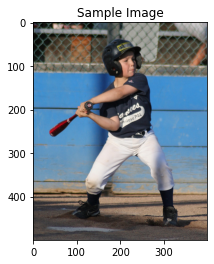

a man in a baseball uniform holding a bat . 


In [20]:
import torch.nn.functional as F
from utils import visualize_cam, Normalize, print_examples
transform = transforms.Compose([
            transforms.Resize((356, 356)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
features,image,orig_image = get_prediction()
normalizer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
torch_img = F.upsample(orig_image[0].permute(2, 0, 1).unsqueeze(0).float().div(255).cuda(), size=(224, 224), mode='bilinear', align_corners=False)
norm_torch_img = normalizer(torch_img)

In [123]:
from utils import find_resnet_layer
images = []
layer_name = encoder.resnet._modules['4'][1].conv1
model_dict = dict(type='resnet',arch=encoder.resnet, layer_name=layer_name,input_size=(224,224))
model_GradCAM = GradCAM(model_dict, True)
norm_torch_img.requires_grad = True
# print(norm_torch_img.requires_grad)
mask , logit = model_GradCAM(norm_torch_img)
mask = mask.cpu()
heatmap_t, result_t = visualize_cam(mask,torch_img)
images.append(torch.stack([torch_img.squeeze().cpu(),heatmap_t,result_t],0))

images = make_grid(torch.cat(images,0),nrow=5)

21_02_35


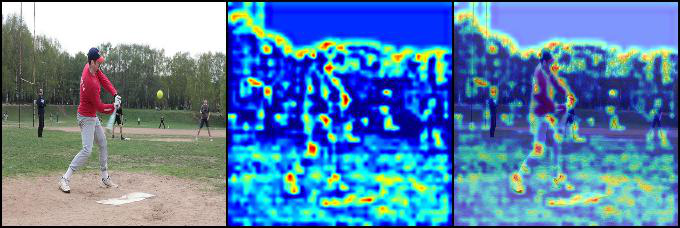

In [125]:
from datetime import datetime
now = datetime.now()
dt_string = now.strftime("%H_%M_%S")
print(dt_string)
output_dir = 'outputs'
os.makedirs(output_dir, exist_ok=True)

output_name = dt_string+"output.JPEG"
output_path = os.path.join(output_dir, output_name)

save_image(images, output_path)
Image.open(output_path)

RESTRUCTURING THE ENCODER

In [80]:
from torchsummary import summary
import torchvision.models as models
import torch.nn as nn


resnet = models.resnet152(pretrained=True)
summary(resnet.fc)
# print(resnet.fc.in_features)
modules = list(resnet.children())

# print(modules[-1])
# modules[-1] = nn.Linear(modules[-1].in_features, embed_size)
modules.pop(-3)
len(modules)

Layer (type:depth-idx)                   Param #
└─Linear: 0-1                            2,049,000
Total params: 2,049,000
Trainable params: 2,049,000
Non-trainable params: 0


9

LSTM based saliency

In [26]:
import torch.nn.functional as F
from utils import visualize_cam, Normalize, print_examples
transform = transforms.Compose([
            transforms.Resize((356, 356)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
# features,image,orig_image = get_prediction()
normalizer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
torch_img = F.upsample(orig_image[0].permute(2, 0, 1).unsqueeze(0).float().div(255).cuda(), size=(224, 224), mode='bilinear', align_corners=False)
norm_torch_img = normalizer(torch_img)
norm_torch_img.requires_grad = True

NameError: name 'orig_image' is not defined

In [24]:
from lstm_saliency import Saliency

saliency_object = Saliency(encoder,decoder)
temp,temp_2 = saliency_object(raw_input)
# layer_name = encoder.resnet._modules['4'][1].conv1
# model_dict = dict(type='resnet',arch=encoder.resnet, layer_name=layer_name,input_size=(224,224))
# model_GradCAM = GradCAM(model_dict, True)
# norm_torch_img.requires_grad = True

Linear(in_features=512, out_features=10321, bias=True)


NameError: name 'raw_input' is not defined